<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
!pip3 install torchinfo
from torchinfo import summary

In [6]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

Esta celda entrena el modelo de traducción automática mediante un ciclo que procesa los datos por épocas. En cada iteración, el modelo aprende de los datos de entrenamiento y se valida con ejemplos no vistos.

El proceso calcula dos métricas principales: la pérdida (loss) que indica el error del modelo, y la precisión (accuracy) que mide el porcentaje de palabras traducidas correctamente.

Los resultados se almacenan para analizar la evolución del aprendizaje y el rendimiento final del modelo traductor.

In [7]:
def sequence_acc(output, target):
    predictions = output.argmax(dim=-1)

    correct = (predictions == target).float()


    accuracy = correct.mean()
    return accuracy

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:

            train_encoder_input = train_encoder_input.to(device)
            train_decoder_input = train_decoder_input.to(device)
            train_target = train_target.to(device)

            # Seteo los gradientes en cero
            optimizer.zero_grad()

            # Forward pass
            output = model(train_encoder_input, train_decoder_input)

            loss = criterion(output.reshape(-1, output.shape[-1]),
                           train_target.reshape(-1))

            # Almaceno el error del batch
            epoch_train_loss += loss.item()

            loss.backward()
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = sequence_acc(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        model.eval()
        with torch.no_grad():
            valid_encoder_input, valid_decoder_input, valid_target = next(iter(valid_loader))
            valid_encoder_input = valid_encoder_input.to(device)
            valid_decoder_input = valid_decoder_input.to(device)
            valid_target = valid_target.to(device)

            output = model(valid_encoder_input, valid_decoder_input)

            epoch_valid_loss = criterion(output.reshape(-1, output.shape[-1]),
                                       valid_target.reshape(-1))
            epoch_valid_loss = epoch_valid_loss.item()
            valid_loss.append(epoch_valid_loss)

            epoch_valid_accuracy = sequence_acc(output, valid_target).item()
            valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### 1 - Datos

In [8]:
import os
import gdown
import zipfile

# Verificar si la carpeta ya existe
if not os.path.exists('spa-eng'):
    # Descargar zip si no existe
    if not os.path.exists('spa-eng.zip'):
        url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
        output = 'spa-eng.zip'
        gdown.download(url, output, quiet=False)
    
    # Descomprimir con Python
    with zipfile.ZipFile('spa-eng.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Dataset descomprimido correctamente.")
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [9]:
# dataset_file

text_file = "./spa-eng/spa.txt"
with open(text_file, encoding="utf-8") as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = len(lines)/4
#MAX_NUM_SENTENCES = 10000

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 29741


In [10]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2 - Preprocesamiento

In [11]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 100000

In [12]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from torch_helpers import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 8085
Sentencia de entrada más larga: 32


In [13]:
# tokenizador de español
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 13917
Sentencia de salida más larga: 36


In [14]:
print(len(word2idx_outputs))
num_words_output

13917


13918

In [15]:
max_input_len = 50
max_out_len = 50

A la hora de realiza padding es importante teneer en cuenta que en el encoder los ceros se agregan al comienoz y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [16]:
from torch_helpers import pad_sequences
np.unicode_ = np.str_

print(np.version.full_version)
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

1.26.4
Cantidad de rows del dataset: 29741
encoder_input_sequences shape: (29741, 50)
decoder_input_sequences shape: (29741, 50)


In [17]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_output_sequences shape: (29741, 50)


Esta celda organiza los datos para el entrenamiento del modelo traductor. Convierte las secuencias de texto en tensores numéricos que PyTorch puede procesar eficientemente.

La clase SequenceDataset estructura tres componentes esenciales: las secuencias de entrada para el codificador, las secuencias de entrada para el decodificador y las secuencias objetivo que el modelo debe aprender a predecir.

Cada muestra del dataset contiene un trio de tensores listos para ser utilizados durante el entrenamiento del modelo de traducción automática.

In [18]:
class SequenceDataset(Dataset):
    def __init__(self, enc_input, dec_input, dec_output):
        self.enc_tensors = torch.from_numpy(enc_input.astype(np.int32))
        self.dec_in_tensors = torch.from_numpy(dec_input.astype(np.int32))
        self.dec_out_tensors = torch.from_numpy(dec_output.astype(np.int64))
        self.n_samples = self.dec_out_tensors.shape[0]

    def __getitem__(self, idx):
        return self.enc_tensors[idx], self.dec_in_tensors[idx], self.dec_out_tensors[idx]

    def __len__(self):
        return self.n_samples

data_set = SequenceDataset(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

 División de Datos para Entrenamiento

In [19]:
torch.manual_seed(42)
val_size = int(len(data_set) * 0.2)
tr_size = len(data_set) - val_size

training_data = torch.utils.data.Subset(data_set, range(tr_size))
validation_data = torch.utils.data.Subset(data_set, range(tr_size, len(data_set)))

print("Muestras de entrenamiento:", len(training_data))
print("Muestras de validación:", len(validation_data))

train_dl = torch.utils.data.DataLoader(training_data, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(validation_data, batch_size=16, shuffle=False)

Muestras de entrenamiento: 23793
Muestras de validación: 5948


### 3 - Preparar los embeddings

In [20]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


Esta celda define las clases para cargar y gestionar embeddings de palabras preentrenados (Glove y FastText). Permite convertir palabras a vectores numéricos y viceversa, manejar la serialización de los embeddings mediante pickle para optimizar la carga, y crear embeddings a partir de archivos de texto si no existe la versión serializada. También incluye métodos de acceso y conversión de índices a palabras y de palabras a índices.

In [21]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        embedding_file = Path(self.PKL_PATH)
        if not embedding_file.exists():
            text_embedding_file = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert text_embedding_file.exists(), 'Embedding file missing'
            word_vectors = self._create_pickle_embeddings()
        else:
            word_vectors = self._load_pickle_embeddings()

        self.word_vectors = word_vectors

        indices = np.arange(self.word_vectors.shape[0])
        self.word_to_index = dict(zip(self.word_vectors['word'], indices))
        self.index_to_word = dict(zip(indices, self.word_vectors['word']))

    def get_words_embeddings(self, word_list):
        indices = self._convert_words_to_indices(word_list)
        return self.word_vectors[indices]['embedding']

    def _convert_words_to_indices(self, word_list):
        return np.array([self.word_to_index.get(word, -1) for word in word_list])

    def _convert_indices_to_words(self, indices):
        return np.array([self.index_to_word.get(idx, '-1') for idx in indices])

    def _load_pickle_embeddings(self):
        self.logger.debug(f'Loading embeddings from {self.PKL_PATH}')
        chunk_size = 2**28 - 1
        data_bytes = bytearray(0)
        file_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as file:
            for _ in range(0, file_size, chunk_size):
                data_bytes += file.read(chunk_size)
        embeddings = pickle.loads(data_bytes)
        self.logger.debug('Embeddings loaded successfully')
        return embeddings

    def _create_pickle_embeddings(self):
        self.logger.debug(f'Converting embeddings from {self.WORD_TO_VEC_MODEL_TXT_PATH}')
        dtype_spec = [
            ('word', np.dtype(f'U{self.WORD_MAX_SIZE}')),
            ('embedding', np.float32, (self.N_FEATURES,))
        ]
        structure = np.dtype(dtype_spec)

        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as text_file:
            embedding_generator = (
                (line.split()[0], line.split()[1:]) for line in text_file
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings_array = np.fromiter(embedding_generator, structure)

        empty_embedding = np.array(
            [('empty_token', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings_array = np.concatenate([embeddings_array, empty_embedding])

        max_bytes = 2**28 - 1
        serialized_data = pickle.dumps(embeddings_array, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as output_file:
            for pos in range(0, len(serialized_data), max_bytes):
                output_file.write(serialized_data[pos:pos+max_bytes])

        self.logger.debug('Embeddings conversion completed')
        return embeddings_array


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [22]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [23]:
# Crear la Embedding matrix de las secuencias
# en ingles

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 98


### 4 - Entrenar el modelo

Esta celda define la arquitectura de la red secuencial para traducción basada en PyTorch. Se incluyen tres clases principales: EncoderNetwork, que codifica la secuencia de entrada en un estado oculto utilizando embeddings preentrenados y LSTM; DecoderNetwork, que decodifica el estado oculto para generar predicciones de salida palabra por palabra; y SequenceModel, que integra el encoder y el decoder en un modelo completo. También se inicializan el modelo, el optimizador y la función de pérdida, y se imprime un resumen de la arquitectura.

In [24]:
class EncoderNetwork(nn.Module):
    def __init__(self, vocab_dim):
        super().__init__()
        self.hidden_dim = 128
        self.n_layers = 1
        self.embed_dim = embed_dim
        self.embed_layer = nn.Embedding(num_embeddings=vocab_dim, embedding_dim=self.embed_dim, padding_idx=0)
        self.embed_layer.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embed_layer.weight.requires_grad = False
        self.lstm_cell = nn.LSTM(input_size=self.embed_dim, hidden_size=self.hidden_dim, batch_first=True,
                                num_layers=self.n_layers)

    def forward(self, input_seq):
        embedded = self.embed_layer(input_seq)
        lstm_out, hidden_state = self.lstm_cell(embedded)
        return hidden_state

class DecoderNetwork(nn.Module):
    def __init__(self, vocab_dim, output_dim):
        super().__init__()
        self.hidden_dim = 128
        self.n_layers = 1
        self.embed_dim = embed_dim
        self.output_dim = output_dim

        self.embed_layer = nn.Embedding(num_embeddings=vocab_dim, embedding_dim=self.embed_dim, padding_idx=0)
        self.lstm_cell = nn.LSTM(input_size=self.embed_dim, hidden_size=self.hidden_dim, batch_first=True,
                                num_layers=self.n_layers)
        self.output_layer = nn.Linear(in_features=self.hidden_dim, out_features=self.output_dim)

    def forward(self, input_seq, prev_hidden):
        embedded = self.embed_layer(input_seq)
        lstm_out, current_hidden = self.lstm_cell(embedded, prev_hidden)
        predictions = self.output_layer(lstm_out[:, -1, :])
        return predictions, current_hidden

class SequenceModel(nn.Module):
    def __init__(self, encoder_net, decoder_net):
        super().__init__()

        self.encoder_net = encoder_net
        self.decoder_net = decoder_net

        assert encoder_net.hidden_dim == decoder_net.hidden_dim, \
            "Encoder and decoder hidden dimensions must match"
        assert encoder_net.n_layers == decoder_net.n_layers, \
            "Encoder and decoder layer counts must match"

    def forward(self, enc_input, dec_input):
        hidden_state = self.encoder_net(enc_input)
        decoder_output, _ = self.decoder_net.lstm_cell(self.decoder_net.embed_layer(dec_input), hidden_state)
        final_output = self.decoder_net.output_layer(decoder_output)
        return final_output

encoder_net = EncoderNetwork(vocab_dim=nb_words)
if cuda: encoder_net.cuda()

decoder_net = DecoderNetwork(vocab_dim=num_words_output, output_dim=num_words_output)
if cuda: decoder_net.cuda()

model = SequenceModel(encoder_net, decoder_net)
if cuda: model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()
if cuda:
    criterion = criterion.to(device)

enc_sample, dec_input_sample, dec_output_sample = data_set[0:1]
summary(model, input_data=(enc_sample.to(device), dec_input_sample.to(device)))

Layer (type:depth-idx)                   Output Shape              Param #
SequenceModel                            [1, 50, 13918]            --
├─EncoderNetwork: 1-1                    [1, 1, 128]               --
│    └─Embedding: 2-1                    [1, 50, 50]               (404,250)
│    └─LSTM: 2-2                         [1, 50, 128]              92,160
├─DecoderNetwork: 1-2                    --                        --
│    └─Embedding: 2-3                    [1, 50, 50]               695,900
│    └─LSTM: 2-4                         [1, 50, 128]              92,160
│    └─Linear: 2-5                       [1, 50, 13918]            1,795,422
Total params: 3,079,892
Trainable params: 2,675,642
Non-trainable params: 404,250
Total mult-adds (Units.MEGABYTES): 12.11
Input size (MB): 11.90
Forward/backward pass size (MB): 5.71
Params size (MB): 12.32
Estimated Total Size (MB): 29.93

In [25]:
hist = train(model,train_dl,val_dl,optimizer,criterion,epochs=10)

Epoch: 1/10 - Train loss 0.810 - Train accuracy 0.886 - Valid Loss 0.585 - Valid accuracy 0.906
Epoch: 2/10 - Train loss 0.614 - Train accuracy 0.897 - Valid Loss 0.538 - Valid accuracy 0.915
Epoch: 3/10 - Train loss 0.531 - Train accuracy 0.902 - Valid Loss 0.527 - Valid accuracy 0.914
Epoch: 4/10 - Train loss 0.471 - Train accuracy 0.907 - Valid Loss 0.534 - Valid accuracy 0.915
Epoch: 5/10 - Train loss 0.424 - Train accuracy 0.912 - Valid Loss 0.551 - Valid accuracy 0.915
Epoch: 6/10 - Train loss 0.387 - Train accuracy 0.917 - Valid Loss 0.567 - Valid accuracy 0.915
Epoch: 7/10 - Train loss 0.357 - Train accuracy 0.922 - Valid Loss 0.579 - Valid accuracy 0.913
Epoch: 8/10 - Train loss 0.332 - Train accuracy 0.926 - Valid Loss 0.579 - Valid accuracy 0.915
Epoch: 9/10 - Train loss 0.313 - Train accuracy 0.929 - Valid Loss 0.608 - Valid accuracy 0.918
Epoch: 10/10 - Train loss 0.298 - Train accuracy 0.932 - Valid Loss 0.606 - Valid accuracy 0.918


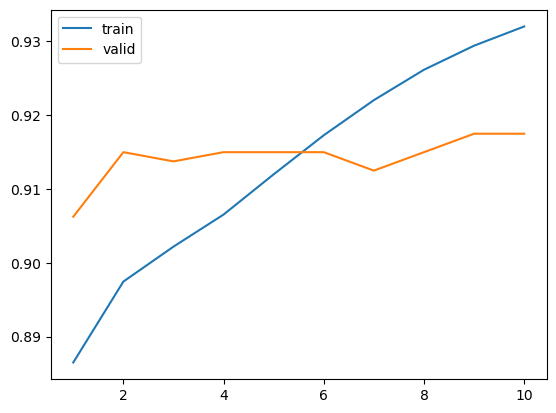

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist['val_accuracy'], label='valid')
plt.show()

El modelo ya alcanzó su punto óptimo muy temprano y seguir entrenando no mejora el rendimiento en datos nuevos. El valor de precisión se considera aceptable.

### 5 - Inferencia

In [27]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [28]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    prev_state = model.encoder_net(encoder_sequence_test_tensor.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, new_prev_state = model.decoder_net(target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)

In [32]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: Tom is naked.
Response: tom es un embustero


In [33]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: I can't hear you.
Response: no puedo culparos


In [34]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: I've got nothing to say to him.
Response: no puedo evitar pensar que tom


In [35]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: She seemed to be suffering a heart attack.
Response: ella no pudo entender ni una sola palabra


In [36]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: Don't pretend what you don't feel.
Response: no dejes que te sientas tengas


Solucionados los problemas de compatibilidades y con la idea de poder usar la totalidad del dataset para el entrenamiento, se reemplazo la implementación del one-hot que consumia demasiada ram, se aumentó el tamaño del dataset.
El modelo implmentado en eta notebook es el mas grande que llegué a correr hasta ahora. Modelos mas chicos. menos neuronas, arrojaron resultados peores. El modelo corre consiedrablemente mas rápido en GPU (colab) pero experimenté muchos problemas de conexión con el servidor 
Si bien el modelo respeta el orden gramatical general del españo y genera frases cohorentes, el embedding y la arquitectura seq2seq funciona, las traducciones son débiles o incompletas y se pierde la semantica de las oraciones. Esto es probable que se pueda solucionar aumentando aún mas el tamaño del dataset o aumentando las capas LSTM. La arquitectura implementada no requiere de demasiadas epochs para la convergencia. 